# Curating and analyzing a Twitter account (community/movement) and its audience

Roni Bulent Ozel - bulent@lucidminds.ai

The noteboook below is prepared for AYARF ([The Asia Young Activist Researcher Fellowship](https://www.ayarf.net/about-the-fellowship)) programme. It aims to present a stages of a typical data collection and analayses -as well as- potentials of machine learning and data analyses tools at capturing and gaining insight on individuals or movements.


### Outline
- Harvesting data
  - Connecting to the Twitter API
  - Collecting the list of followers of an account
  - Collecting the list followers of the member(followers) of a movement/community/account
  - Collecting tweets of an account
  - Collecting tweets of all of the followers
- Curating data
  - Cleaning the textual data
  - Extracting:
    - keywords
    - retweets
    - mentions
    - hashtags
  - Curating data on members of a community
- Reconstructing 
  - Forming who-mentions-whom relations
  - Forming who-retweets-whom relations
  - Forming who-follows-whom relations
- Viusalizing
  - who-mentions-whom network
  - who-retweets-whom network
  - who-follows-whom network
- Analyzing
  - Retweeting patterns
  - Mention patterns
- Modelling
  - Topic modelling
    
  


In [1]:
# Stantard base Python modules
import re, json, oauth2, pickle, math

# Data API connection and authentication tool
import oauth2

# Basic Data Analytics tools
import pandas as pd
import numpy as np

# Social Network Analysis tools
import networkx as nx

# Custom Text Processing tools
from omterms.interface import *

# Natural Language Processing tools
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF

# Data Visualization and Display tools
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib as mpl
import pprint

In [2]:
pp = pprint.PrettyPrinter(indent=2)
% matplotlib inline

In [3]:
class MyTwitterAPI:

    Consumer_Key = ""  # API key
    Consumer_Secret = ""  # API secret

    Access_Token = ""
    Access_Token_Secret = ""

    url_api = "https://api.twitter.com/1.1/statuses/user_timeline.json?tweet_mode=extended"
    url_followers = "https://api.twitter.com/1.1/followers/list.json"
    fixed_params = "?skip_status=true&include_user_entities=false&count=200"

    def __init__(self, new=None):
        if new:
            self.consumer = oauth2.Consumer(key=new['Consumer_Key'], secret=new['Consumer_Secret'])
            self.access_token = oauth2.Token(key=new['Access_Token'], secret=new['Access_Token_Secret'])
            self.Client = oauth2.Client(self.consumer, self.access_token)
        else:
            self.consumer = oauth2.Consumer(key=MyTwitterAPI.Consumer_Key, secret=MyTwitterAPI.Consumer_Secret)
            self.access_token = oauth2.Token(key=MyTwitterAPI.Access_Token, secret=MyTwitterAPI.Access_Token_Secret)
            self.Client = oauth2.Client(self.consumer, self.access_token)


    def accumulate_auser_tweets(self, auser, nlatest = 200, merge = True):
        # type: (str, int) -> dict
        def get_content(tweet):
            lang = tweet['lang']
            if 'retweeted_status' in tweet.keys():
                rtu = "RT @" + tweet['retweeted_status']['user']['screen_name'] + ': '
                content = rtu + tweet['retweeted_status']["full_text"]
            else:
                content = tweet["full_text"]
            return {'lang':lang, 'text': content}

        request = MyTwitterAPI.url_api + "&screen_name="+ auser + "&count=" + str(nlatest)
        response, data = self.Client.request(request)
        tweets = json.loads(data)
        #pp.pprint(tweets)
        print("="*20)
        print('{} {}'.format(auser, not isinstance(tweets, dict)))
        if isinstance(tweets, dict):
            message = tweets['errors'][0]['message']
            print("Connection error to the account {}".format(auser))
            raise Exception(message)
        user_content = [get_content(t) for t in tweets]
        if merge:
            user_content = [t['text'] for t in user_content if t['lang'] == 'en']
            user_content = '\n'.join(user_content)

        return {"ntweets": len(tweets), "content": user_content}


    def retrieve_tweets(self, userlist, nlatest=200, merge = True):
        tweets = dict()
        userlist = [str(x) for x in userlist if isinstance(x, str)]
        for user in userlist:
            try:
                tweets[user] = self.accumulate_auser_tweets(user,nlatest, merge)
            except Exception as e:
                tweets[user] = {"ntweets": 0, "content": ""}
        return tweets

    def _get_followers(self, auser, acursor="-1", fnames=set(), minfollow = 0):
        if acursor == str(0): return fnames
        request = MyTwitterAPI.url_followers + MyTwitterAPI.fixed_params + "&screen_name=" + auser + "&cursor=" + acursor
        response, data = self.Client.request(request)
        fdata = json.loads(data)
        #print('response:', auser)
        print(fdata.keys())
        #pp.pprint(response)
        if 'error' in fdata.keys() or 'errors' in fdata.keys():
            #message = fdata['error'][0]['message']
            #print("Connection error to the account {}".format(auser))
            pp.pprint(fdata)
            return fnames
        next_cursor = fdata['next_cursor_str']
        dfollowers = fdata['users']
        fnames = fnames.union([x['screen_name'] for x in dfollowers if x['followers_count'] > minfollow])
        #pp.pprint(fnames)
        return self._get_followers(auser, acursor = next_cursor, fnames = fnames)

    def retrieve_followers(self, userlist, minfollow=0):
        #userlist = ['bulentozel']
        follower_distro = dict()
        follower_lists = dict()
        userlist = [str(x) for x in userlist if isinstance(x, str)]
        for user in userlist:
            followers = self._get_followers(user, acursor="-1", fnames=set(), minfollow = minfollow)
            follower_lists[user] = list(followers)
            follower_distro[user] = len(followers)
        return {'lists':follower_lists, 'distro':follower_distro}

In [4]:
def harvest_tweets(followers, fname=None):
    done = set()
    notdone = set(followers).difference(done)
    for auser in notdone:
        debates = ClientTwitter.retrieve_tweets([auser], nlatest = 200, merge = False)
        tweets = debates[auser]['content']
        if not fname:
            fname = './output/tweets/' + auser +'.pickle'
        with open(fname, 'wb') as handle:
            pickle.dump(tweets, handle, protocol=pickle.HIGHEST_PROTOCOL)
        done.add(auser)
        print('Done: {}'.format(auser))
    notdone = set(followers).difference(done)
    return done, notdone

In [5]:
def update_followersof_followers(accumulated, newdata):
    nnew = 0
    for f, lof in newdata['lists'].items():
        if not lof: continue
        nnew += 1
        accumulated['distro'][f] = newdata['distro'][f]
        accumulated['lists'][f] = newdata['lists'][f]
    print(nnew, "new entries are added", sep=" ")
    return [k for k,v in accumulated['distro'].items() if v == 0]

In [6]:
# Routines and objects that curates content of the microblogging.

class Tweets:
    re_rt = re.compile(r"RT @.*?:")
    re_url = re.compile("(?P<url>https?://[^\s]+)")
    re_ht_valid = re.compile(r"^[a-zA-Z]+[a-zA-Z0-9]*")
    
    def __init__(self, tweets = []):
        print('The tweet extractor class is initiated with {} tweets'.format(len(tweets)))
    
    def extract_info(self,tweets, kw = True):
        return [{'rt': self.is_rt(t),
                 'rt_from': self.rt_from(t),
                 'mentions': self.extract_mentions(t),
                 'hashtags': self.extract_hashtags(t),
                 'keywords': self.extract_keywords(t, kw),
                 'text': self.clean_text(t)} for t in tweets
               ]
            
    def is_rt(self, tweet):
        tweet = tweet['text']
        search = re.search(self.re_rt, tweet)
        return True if search else False
    
    def rt_from(self, tweet):
        matched = re.match(self.re_rt, tweet['text'])
        if not matched: return set()
        tweet['text'] = matched.group()
        return self.extract_mentions(tweet, no_rt=False)
    
    def remove_rt(self, tweet):
        tweet = tweet['text']
        return re.sub(self.re_rt, r' ', tweet)
    
    def extract_urls(self, tweet):
        tweet = tweet['text']
        search = re.search(self.re_url, tweet)
        if search: return search.group("url")
        
    def remove_urls(self, tweet):
        tweet = tweet['text']
        return re.sub(self.re_url, r' ', tweet)
    
    def extract_mentions(self, tweet, no_rt = True):
        tweet = tweet['text']
        if no_rt: tweet = re.sub(self.re_rt, r' ', tweet)
        mentions = set(t[1:] for t in tweet.split() if t.startswith('@'))
        return set([m[:-1] if m.endswith(':') else m for m in mentions])
    
    def extract_hashtags(self, tweet):
        tweet = tweet['text']
        hts = [t[1:] for t in tweet.split() if t.startswith('#')]
        valid_hts = set()
        for ht in hts:
            matched = re.match(self.re_ht_valid, ht)
            if not matched: continue
            valid_hts.add(matched.group())  
        return valid_hts
    
    def remove_mentions(self, tweet):
        tweet = tweet['text']
        tokens = tweet.split()
        mentions = set(t for t in tokens if t.startswith('@'))
        return ' '.join([t for t in tokens if t not in mentions])
    
    def clean_text(self, tweet):
        tweet['text'] = self.remove_urls(tweet)
        tweet['text'] = self.remove_rt(tweet)
        return self.remove_mentions(tweet)
    
    def extract_keywords(self, tweet, kw = True):
        if not kw: return set()
        if tweet['lang'] != 'en': return set()
        text = self.clean_text(tweet)
        return set(extract_terms(text, min_termlength=2, min_tf=0).Term)

# Methods:

def has_info(data):
    for k,v in data.items():
        if v: return True
    return False
    
def curate_user(auser, curator, kw = True):
    fname = './output/tweets/' + auser +'.pickle'
    with open(fname, 'rb') as handle:
        tweets = pickle.load(handle)
    n = len(tweets)
    print('{}: {}'.format(auser,n))
    curated = curator.extract_info(tweets, kw)
    curated = [c for c in curated if has_info(c)]
    return n, curated

def curate_followers(followers,
                     kw = True,
                     store = True,
                     fpath ='./output/fresh_data'):
    """It proccesses and analyzes each follower's each tweets one by one.
    
    Note:
        Examining tweets one by one specifically to clean, tokenize and standardize and
        extract terms is relatively costly in terms of time.
    
    Args:
        followers (:obj:`set` of  :obj:`str`): A set of twitter account's screen names.
        kw (:obj:`bool`): When True extract terms of each tweets (default True).
    
    Returns:
        (:obj:`dict`): A JSON like collection of curated data.
            Each entry in the collection represents a curated twitter data.
    
    """
    curated = dict()
    mT = Tweets()
    for f in followers:
        n, data = curate_user(f, mT, kw)
        curated[f] = {'ntweets':n,'data':data}
    if store: store_curated_data(curated, fpath)
    return curated

def store_curated_data(data, filepath):
    fpickle = filepath + '.pickle'
    with open(fpickle, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        print(fpickle)
        
#prepare tokenized keywords for the keyword cloud
def combine_curated_tweets(acurated_account):
    keyword_lists = [list(d['keywords']) for d in acurated_account[1]]
    text= " ".join([kw for kw_l in keyword_lists for kw in kw_l])
    keyword_lists = [list(d['hashtags']) for d in acurated_account[1]]
    hashtags = " ".join([kw for kw_l in keyword_lists for kw in kw_l])
    return {'keywords':text, 'hashtags':hashtags}

In [7]:
# Network analyses routines:

def count_links(connections):
    co = dict()
    for alist in connections:
        for a in alist:
            if a in co.keys():
                co[a] += 1
            else:
                co[a] = 1
    return co

def get_popularity(net):
    popularity = dict()
    for nodes in net.values():
        for node,weight in nodes.items():
            if node in popularity.keys():
                popularity[node] += weight
            else:
                popularity[node] = weight
    return popularity

def get_rt_ratios(curated):
    rt_ratios = dict()
    for a in curated.keys():
        nt = curated[a]['ntweets']
        nrt = sum([1 for d in curated[a]['data'] if d['rt']])
        ratio = nrt/nt if  nt else 0
        rt_ratios[a] = {'nTweet':nt,
                        'nRTweet':nrt,
                        'rDiffusion':ratio}
    return rt_ratios


def extract_relations(curated, linktype='mentions'):
    relations = dict()
    for a in curated.keys():
        links = [d[linktype] for d in curated[a]['data'] if d[linktype]]
        relations[a] = count_links(links)
    return relations

def select_subnet(net, nodes, isin = True):
    if isin:
        return {n:{m:w for m,w in links.items() if m in nodes} for n,links in net.items() if n in nodes}
    else:
        return {n:{m:w for m,w in links.items() if m not in nodes} for n,links in net.items() if n in nodes}
    
def drop_isolates(net):
    net = {n:{m:w for m,w in links.items() if m != n} for n,links in net.items()}
    isolates = [n for n,w in net.items() if not w]
    nonisolates = {n:w for n,w in net.items() if w}
    return nonisolates, isolates

def get_cohesion_ratios(net, nodes):
    cohesion = dict()
    for node,links in net.items():
        internal = sum([w for n,w in links.items() if n in nodes])
        external = sum([w for n,w in links.items() if n  not in nodes])
        total = internal + external
        cohesion[node] = {'in': internal,
                          'out': external,
                          'ratio': internal / total if total else 0
                         }
    return cohesion

In [8]:
# Some custom visualization routines
def display_wordcloud(text, fontsize=100, maxwords=50):
    wordcloud = WordCloud(max_font_size=fontsize, max_words=maxwords, background_color="white").generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

-----

## 1. Harvesting data

### 1.1 Connecting to the Twitter API

#### Getting Twitter API Credentials
In order to get credentials to be able to connect to the Twitter:
- Login to https://apps.twitter.com
 - If you already have twitter application you may use its credentials.
 - Or generate a new set of keys and tokens via "Create a New App" button.
- Click "Keys and Access Tokens" tab and copy "API key", API secret".
- Click "Create my Access Token" and copy "Access token" and "Access token secret".

### 1.2 Collecting the list of followers of an account
The account may represent a community, a movement, a political party, etc

####  Instantiating the custom Twitter interface
 A custom API is developed that interacts with Twitter API interface. It was originally developed for the Community Spirals API project.

In [9]:
Credentials = {}
Credentials['Consumer_Key'] = "UM00WPC9LWpMVsrhPchvGJ2i7" 
Credentials['Consumer_Secret'] = "ikdfWBLyuU3W9YF5UslvR05EzCIbzniilVt28yYQOUuRjbtbxp"
Credentials['Access_Token'] = "95098920-yR4A2DMVoXf3O8tyWfAJN76Zw7CafXk9eU0dsvtA8" 
Credentials['Access_Token_Secret'] = "wXV3rUYLmGN0rO0E6ZC1pWkn4A1EAVh74jF3W3Kk0suJC"

In [10]:
ClientTwitter = MyTwitterAPI(Credentials)

#### Setting the account.

In [11]:
account = 'bulentozel'

#### Retrieving the list of followers of the account

The following API connection is to be used when updating the list of followers. It will take time and will be subject to API limitations determined by Twitter platform. Uncomment it otherwise.

In [12]:
follower_data = ClientTwitter.retrieve_followers([account])

dict_keys(['users', 'next_cursor', 'next_cursor_str', 'previous_cursor', 'previous_cursor_str', 'total_count'])


In [13]:
pp.pprint(follower_data['distro'])

{'bulentozel': 128}


In [14]:
followers = follower_data['lists'][account]

#### Saving the list of followers for later re-use


In [15]:
fname = './output/lists/' + account +'_followers.pickle'
print(fname)
with open(fname, 'wb') as handle: pickle.dump(followers, handle, protocol=pickle.HIGHEST_PROTOCOL)

./output/lists/bulentozel_followers.pickle


#### Reloading the harvested list
This is needed when a previously collected list of followers are to be used.

In [16]:
fname = './output/lists/' + account +'_followers.pickle'
print(fname)
with open(fname, 'rb') as handle:
    followers = pickle.load(handle)
len(followers)

./output/lists/bulentozel_followers.pickle


128

### 1.3 Collecting the list followers of the member(followers) of a movement/community/account
This step can take time and may require a paid API request. The script below is for a demonstration purpose and for a not automated/streamed data collection.

In [17]:
# add the account for data curation for network ties.
notdone = followers
if account not in followers: followers.append(account)
newdata = {'distro':{account:len(followers)},'lists':{account:followers}}

In [18]:
len(followers)

129

#### Loading previously collected lists


In [19]:
fname = './output/lists/' + account +'_FoFollowers.pickle'
print(fname)
with open(fname, 'rb') as handle:
    FoFollowers= pickle.load(handle)
notdone = [k for k,v in FoFollowers['distro'].items() if v == 0]

./output/lists/bulentozel_FoFollowers.pickle


In [20]:
#pp.pprint(FoFollowers)

In [21]:
notdone = update_followersof_followers(FoFollowers, newdata)

1 new entries are added


#### Curate new lists

Uncomment when you incrementally collect list of followers of the followers

In [22]:
#ClientTwitter = MyTwitterAPI(Credentials)
#newdata = ClientTwitter.retrieve_followers(notdone, minfollow=1)    

In [23]:
len(notdone), len([k for k,v in FoFollowers['distro'].items() if v])

(20, 108)

In [24]:
#check new addtions
for f, lof in newdata['lists'].items():
    if not lof: continue
    print(f)

#update accumalted dataset
notdone = update_followersof_followers(FoFollowers, newdata)

print(len(notdone), len([k for k,v in FoFollowers['distro'].items() if v]), sep= " ")

fname = './output/lists/' + account +'_FoFollowers.pickle'
print(fname)
with open(fname, 'wb') as handle:
    pickle.dump(FoFollowers, handle, protocol=pickle.HIGHEST_PROTOCOL)

bulentozel
1 new entries are added
20 108
./output/lists/bulentozel_FoFollowers.pickle


### 1.4 Retrieving tweets of the account

In [25]:
harvest = harvest_tweets([account])

bulentozel True
Done: bulentozel


### 1.5 Retrieving tweets of the followers of the account
Uncomment the cell below, when updating and re-harvesting twitters of the followers is needed. It will take time and will be subject to limitations.

In [26]:
#harvest = harvest_tweets(followers)

#### A quick examination of harvested data.

In [27]:
for auser in followers:
    fname = './output/tweets/' + auser +'.pickle'
    with open(fname, 'rb') as handle:
        tweets = pickle.load(handle)
    print('{}: {}'.format(auser,len(tweets)))

AkifMag: 200
dariomarmo_lama: 200
tanbark: 192
sevtrkci: 4
akcabilgi: 0
cyphies: 195
fkoksal: 26
hanwoopark: 200
p_pinardemirel: 58
Jakdemir: 197
MelihSungur: 0
egulcin: 35
oykuisik: 200
EinarJonErlings: 196
studioagena: 200
mentionlan: 0
strafor: 179
collnet2011: 2
omerfarukustun: 2
Radyo1959: 200
gercekalpan: 192
chrisjstephensn: 200
yasarcanyilmaz: 198
bpapila: 198
nhoening: 200
anjaVnic: 4
DamlaSargut: 192
CaiAmir: 1
mefallit: 200
savasy: 194
zeuran: 189
ruzgarbasar: 173
SedefNakliye: 0
mpehlivan15: 193
Goran1st: 1
mertozcn: 190
damladural: 200
EstebanFabio: 0
CsTweetShare: 9
RakinRaks: 199
akincih: 174
JSCIRES: 200
erenturkay: 200
neurolojik: 193
ucekmez: 195
k_necdet: 4
oyayla_: 200
EmreSevinc: 200
DVisotto: 0
GulcinOymak: 2
SerraZel: 12
Baharmur: 14
gekotek: 198
hayatikolpaadam: 10
bitblastr: 23
elsaninmecnunu: 198
kkakkoyun: 200
onurgu: 199
mcancicek: 0
aras_kand: 0
onur_tig: 29
zanagalip: 191
selene_uras: 34
thelastdinasour: 72
temmuzsr: 197
ZalameraBnB: 10
cagilulusahin: 198


-----

## 2. Curating data
  - Cleaning the textual data
  - Extracting metadata: Retweets, mentions, hashtags

### 2.1 Demo of curating a specific twitter account
Note that only 'mentions' and 'rt_from' fields are listed below.

In [28]:
mT = Tweets()
acurated_account = curate_user('bulentozel', mT, kw=True)

The tweet extractor class is initiated with 0 tweets
bulentozel: 82
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 13
Cleaning process: Initial size of tokens = 13
Reduction due to punctuations and stopwords = 5.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 5
Percentage = 38%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File acce

Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 2
Percentage = 40%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 5
Cleaning process: Initial size of tokens = 5
Reduction due to punctuations and stopwords = 2.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 2
Percentage = 40%
COMPLETED.


Percentage = 0%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 4
Cleaning process: Initial size of tokens = 4
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
Percentage = 0%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, 

##### Number of tweets found and curated:

In [29]:
#acurated_account

(82,
 [{'hashtags': set(),
   'keywords': {'change',
    'climate',
    'day',
    'detectable',
    'global',
    'scale',
    'single',
    'weather'},
   'mentions': set(),
   'rt': False,
   'rt_from': set(),
   'text': '"Climate change now detectable from any single day of weather at global scale":'},
  {'hashtags': {'ABM', 'RegTech', 'lucidminds', 'simulation'},
   'keywords': set(),
   'mentions': set(),
   'rt': False,
   'rt_from': set(),
   'text': '#lucidminds #RegTech #simulation #ABM'},
  {'hashtags': set(),
   'keywords': set(),
   'mentions': set(),
   'rt': True,
   'rt_from': {'oyayla_'},
   'text': ''},
  {'hashtags': {'berlin', 'drinks', 'kickoff', 'lucidminds', 'music'},
   'keywords': {'berlin',
    'cool',
    'cream',
    'drinks',
    'drop',
    'evening',
    'gathering',
    'happen',
    'ice',
    'kick',
    'kickoff',
    'know',
    'lucidminds',
    'may',
    'message',
    'music',
    'organizing',
    'team',
    'tomorrow',
    'town',
    'want'},

In [30]:
acurated_account[0]

82

In [31]:
len(acurated_account[1])

81

##### Fields of curated data

In [32]:
pp.pprint(acurated_account[1][42])

{ 'hashtags': set(),
  'keywords': set(),
  'mentions': set(),
  'rt': True,
  'rt_from': {'tugcetackin'},
  'text': ''}


In [33]:
#pp.pprint([{'Mentions':d['mentions'], 'Retweeted from':d['rt_from']} for d in acurated_account[1]])

#### A first look into keywords

In [34]:
acurated_account_oz = curate_user('oyayla_', mT, kw=True)

oyayla_: 200
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 2
Cleaning process: Initial size of tokens = 2
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
Percentage = 0%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading i

The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at 

Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 3
Percentage = 60%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 34
Cleaning process: Initial size of tokens = 34
Reduction due to punctuations and stopwords = 14.
Reduction due to all numeral terms = 0
Reduction due to short terms = 1
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 15
Percentage = 44%
COMPLETED.
Configuring the text cleaner 

Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is p

Reduction due to short terms = 1
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 4
Percentage = 36%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 15
Cleaning process: Initial size of tokens = 15
Reduction due to punctuations and stopwords = 6.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 6
Percentage = 40%
COMPLETED

Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 5
Cleaning process: Initial size of tokens = 5
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
Percentage = 0%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A 

File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 4
Cleaning process: Initial size of tokens = 4
Reduction due to punctuations and stopwords = 4.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 4
Percentage = 100%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms:

Percentage = 30%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 7
Cleaning process: Initial size of tokens = 7
Reduction due to punctuations and stopwords = 1.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 1
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 2
Percentage = 29%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt

The total term count reduction during this cleaning process = 6
Percentage = 38%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 4
Cleaning process: Initial size of tokens = 4
Reduction due to punctuations and stopwords = 2.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 2
Percentage = 50%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading

The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 10
Cleaning process: Initial size of tokens = 10
Reduction due to punctuations and stopwords = 4.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 4
Percentage = 40%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
Fi

Tokenizing the input text ..
Done. Number of terms: 2
Cleaning process: Initial size of tokens = 2
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
Percentage = 0%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 15
Cleaning process: Initial size of tokens = 15
Reduction due to punctuations and stopwords = 4.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
R

Tokenizing the input text ..
Done. Number of terms: 19
Cleaning process: Initial size of tokens = 19
Reduction due to punctuations and stopwords = 6.
Reduction due to all numeral terms = 0
Reduction due to short terms = 1
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 7
Percentage = 37%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 10
Cleaning process: Initial size of tokens = 10
Reduction due to punctuations and stopwords = 2.
Reduction due to all numeral terms = 1
Reduction due to short terms = 0
Reduction due to rare terms = 

In [35]:
#prepare tokenized keywords for the keyword cloud
keyword_lists = [list(d['keywords']) for d in acurated_account[1]]
text= " ".join([kw for kw_l in keyword_lists for kw in kw_l])

In [36]:
#prepare tokenized keywords for the keyword cloud
keyword_lists = [list(d['keywords']) for d in acurated_account_oz[1]]
text_oz= " ".join([kw for kw_l in keyword_lists for kw in kw_l])

In [37]:
#text

In [38]:
#prepare hastags for the keyword cloud
keyword_lists = [list(d['hashtags']) for d in acurated_account[1]]
hashtags = " ".join([kw for kw_l in keyword_lists for kw in kw_l])

In [39]:
#prepare hastags for the keyword cloud
keyword_lists = [list(d['hashtags']) for d in acurated_account_oz[1]]
hashtags_oz= " ".join([kw for kw_l in keyword_lists for kw in kw_l])

In [40]:
hashtags

'lucidminds simulation RegTech ABM lucidminds music kickoff drinks berlin S paradisepapers AnkaraKatliam Bar CanD DirenGezi DirenTMMOB Kiral direngezi duranadam direngezi direngezi direngezi direngezi direngezi durankadin duranadam direngezi direngezi direngezi direngezi direngezi direngezi'

In [41]:
hashtags_oz

'healthcare ML GDPR climate psychedelic bigdata FridaysforFuture inequality poverty AI AI DataScience ai mortgage DataScience AI privacy blockchain AI brexit AI software DIY maker WIP music turkish news generative creativecoding art ETH BTH economics health prototyping hacking bigdata websites data documentary wikipedia designs minimal python ETL startups popcorn Obama chatbot ai telegram food macbook PepsiCo Uber SpaceX Trump donations donate Aleppo radio Datavisualization AI recipes bot food democracy Bot airbnb facebook Data WhatsApp trump Interview mobile security P2P insurance AWS github interactive history sick ycombinator wikipedia Lenin aisucomic signup ZenMate comic web Cairo Startups world airbnb data spacemacs public Google CanDuendarErdemGuelYaln Spotify Google mix animation python Postgresql SQL Postgresql live stream data tennis visual data hacker Watsi ETL BigData AWS Analytics Python Redshift Amazon twitter opensource R microservices media Berlin hack German refugees Is

In [42]:
#?WordCloud

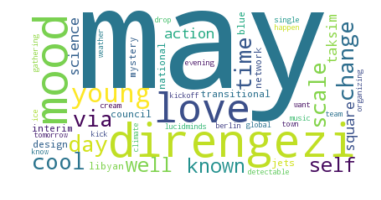

In [43]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white").generate(text)
# Display the keyword cloud of cleaned tweets:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

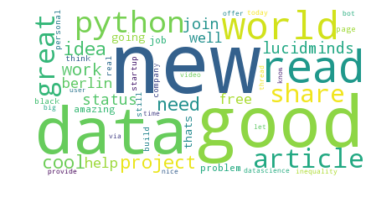

In [44]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white").generate(text_oz)
# Display the keyword cloud of cleaned tweets:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

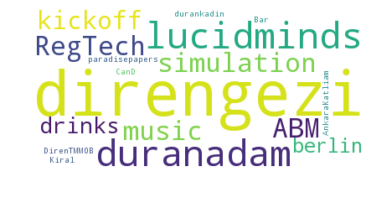

In [45]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=200, max_words=50, background_color="white").generate(hashtags)
# Display the keyword cloud of cleaned tweets:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

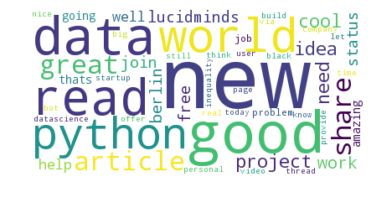

In [46]:
# lower max_font_size, change the maximum number of word and lighten the background:
wordcloud = WordCloud(max_font_size=100, max_words=50, background_color="white").generate(text_oz)
# Display the keyword cloud of cleaned tweets:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.2 Curating the tweets of each member of a community
This is curating data from all followers of an account.

In [47]:
# if keyword extraction is needed set kw to True
# curated = curate_followers(followers, kw = True)

In [48]:
#pp.pprint(curated)
#len(curated)

#### Store the curated data.

In [49]:
#fname = './output/curated/'+ account + '_curated'
#store_curated_data(curated, fname)

#### Load from preveiously curated data.

In [50]:
fname = './output/curated/bulentozel_curated.pickle'
with open(fname, 'rb') as handle:
        curated = pickle.load(handle)

In [51]:
#pp.pprint(curated)
len(curated)

128

In [52]:
curated['oyayla_'].keys()

dict_keys(['ntweets', 'data'])

In [53]:
curated['oyayla_']['ntweets'], len(curated['oyayla_']['data'])

(200, 200)

In [54]:
curated['bulentozel']['ntweets'], len(curated['bulentozel']['data'])

(81, 80)

In [55]:
pp.pprint(curated['bulentozel']['data'])

[ { 'hashtags': {'lucidminds', 'simulation', 'RegTech', 'ABM'},
    'keywords': set(),
    'mentions': set(),
    'rt': False,
    'rt_from': set(),
    'text': '#lucidminds #RegTech #simulation #ABM'},
  { 'hashtags': set(),
    'keywords': set(),
    'mentions': set(),
    'rt': True,
    'rt_from': {'oyayla_'},
    'text': ''},
  { 'hashtags': {'lucidminds', 'music', 'kickoff', 'drinks', 'berlin'},
    'keywords': { 'berlin',
                  'cool',
                  'cream',
                  'drinks',
                  'drop',
                  'evening',
                  'gathering',
                  'happen',
                  'ice',
                  'kick',
                  'kickoff',
                  'lucidminds',
                  'message',
                  'music',
                  'organizing',
                  'team',
                  'tomorrow',
                  'town',
                  'want'},
    'mentions': set(),
    'rt': False,
    'rt_from': set(),
 

    'mentions': set(),
    'rt': False,
    'rt_from': set(),
    'text': '"c&amp;p: -Ne duruyorsun burada? +Arkadaşımı bekliyorum. -Ne '
            'zaman gelecek? +Bilmiyorum. -Adı ne arkadaşının? +Ethem '
            'Sarısülük." #duranadam'},
  { 'hashtags': {'direngezi'},
    'keywords': set(),
    'mentions': set(),
    'rt': False,
    'rt_from': set(),
    'text': '"c&amp;p: -Ne duruyorsun burada? +Arkadaşımı bekliyorum. -Ne '
            'zaman gelecek? +Bilmiyorum. -Adı ne arkadaşının? +Ethem '
            'Sarısülük." #direngezi'},
  { 'hashtags': set(),
    'keywords': set(),
    'mentions': set(),
    'rt': True,
    'rt_from': {'damladural'},
    'text': ''},
  { 'hashtags': {'direngezi'},
    'keywords': set(),
    'mentions': set(),
    'rt': False,
    'rt_from': set(),
    'text': '#direngezi Trump Towers ikizlerini yerle yeksan edecek '
            'muhimmatlar'},
  { 'hashtags': {'direngezi'},
    'keywords': set(),
    'mentions': set(),
    'rt': False,
    'rt_f

    'rt': False,
    'rt_from': set(),
    'text': 'Aheng-i Hengame, December 02, 2010, Acik Radyo'},
  { 'hashtags': set(),
    'keywords': {'hengame', 'november', 'aheng'},
    'mentions': set(),
    'rt': False,
    'rt_from': set(),
    'text': 'Aheng-i Hengame, November 24, 2010'},
  { 'hashtags': set(),
    'keywords': {'truly', 'suicide', 'question', 'philosophical'},
    'mentions': set(),
    'rt': False,
    'rt_from': set(),
    'text': '"there is only one truly philosophical question and that is '
            'suicide…"'},
  { 'hashtags': set(),
    'keywords': {'hamming', 'insight', 'computing', 'numbers', 'purpose'},
    'mentions': set(),
    'rt': False,
    'rt_from': set(),
    'text': '"The purpose of computing is insight – not numbers." R. W. '
            'Hamming (1962)'},
  { 'hashtags': set(),
    'keywords': { 'attachment',
                  'grows',
                  'model',
                  'network',
                  'preferential',
                  'pre

-----

## 3. Reconstructing
 - Forming who-mentions-whom relations
 - Forming who-retweets-whom relations
 - Forming who-follows-whom relations

### 3.1 Reconstructing who-mentions-whom network

In [56]:
Mention_Network = extract_relations(curated, linktype = 'mentions')

In [57]:
#pp.pprint(Mention_Network)

In [58]:
Mention_Network_Internal = select_subnet(Mention_Network, followers)

In [59]:
#pp.pprint(Mention_Network_Internal)

In [60]:
Mention_Network_Internal_Connected, Mention_Network_Internal_Isolates = drop_isolates(Mention_Network_Internal)

In [61]:
pp.pprint(Mention_Network_Internal_Connected)

{ 'AliTaylanCemgil': {'uskudarli': 1},
  'CsTweetShare': {'aren_13': 1},
  'EmreSevinc': {'chrisjstephensn': 1},
  'RakinRaks': {'zanagalip': 1},
  'atilev': {'chrisjstephensn': 1, 'ozselgin': 1},
  'bpapila': {'ozselgin': 1},
  'bulentozel': {'DamlaSargut': 2},
  'canburak': {'EmreSevinc': 4},
  'chazzwazzer': {'onderozbek': 1},
  'chrisjstephensn': {'EmreSevinc': 4, 'iyiailecocugu': 1},
  'damladural': {'akcabilgi': 1, 'taistasi': 5},
  'ercanmuskara': {'elsaninmecnunu': 5},
  'erenturkay': {'EmreSevinc': 3},
  'fkoksal': {'EmreSevinc': 1},
  'gekotek': {'chrisjstephensn': 1, 'oykuisik': 1},
  'heidisgrandpa': {'strafor': 1},
  'itechD': {'EmreSevinc': 1},
  'iyiailecocugu': {'neurolojik': 2},
  'necosphere': {'Baharmur': 1},
  'neurolojik': {'iyiailecocugu': 2},
  'onderozbek': {'chrisjstephensn': 1},
  'oyayla_': {'chrisjstephensn': 1},
  'ozselgin': {'elsaninmecnunu': 4},
  'savasy': {'chrisjstephensn': 1},
  'sevtrkci': {'iyiailecocugu': 2, 'neurolojik': 2},
  'tanbark': {'chazzw

In [62]:
#Mention_Network_Internal_Isolates

### 3.2 Reconstructing who-retweets-whom network

In [63]:
RT_Network = extract_relations(curated, linktype = 'rt_from')
RT_Network_Internal = select_subnet(RT_Network, followers)
RT_Network_Internal_Connected, RT_Network_Internal_Isolates = drop_isolates(RT_Network_Internal)

In [64]:
#pp.pprint(Mention_Network)

In [65]:
#pp.pprint(Mention_Network_Internal)

In [66]:
pp.pprint(RT_Network_Internal_Connected)

{ 'AliTaylanCemgil': {'EmreSevinc': 1, 'uskudarli': 1},
  'Jakdemir': {'cagilulusahin': 3},
  'RakinRaks': {'niceyildiz': 1, 'zanagalip': 14},
  'SerraZel': {'bulentozel': 1},
  'aren_13': {'CsTweetShare': 1, 'chrisjstephensn': 1, 'gekotek': 1},
  'aytac0x': {'erenturkay': 1},
  'bitblastr': {'bulentozel': 1},
  'bpapila': {'chrisjstephensn': 4},
  'bulentozel': { 'Radyo1959': 1,
                  'damladural': 1,
                  'oyayla_': 1,
                  'tugcetackin': 1},
  'cagilulusahin': {'chrisjstephensn': 3},
  'chazzwazzer': {'atilev': 1, 'onurgu': 2},
  'chrisjstephensn': {'gekotek': 1},
  'dariomarmo_lama': {'uskudarli': 1},
  'filizadastephe1': {'chrisjstephensn': 6},
  'fkoksal': {'EmreSevinc': 1},
  'gekotek': {'chrisjstephensn': 4, 'uskudarli': 2},
  'halukdogan': {'chrisjstephensn': 1},
  'itechD': {'chrisjstephensn': 4},
  'mefallit': {'chrisjstephensn': 1},
  'mericsucuk': {'zeuran': 2},
  'neurolojik': {'gekotek': 1, 'kkakkoyun': 1},
  'onurgu': {'erenturkay':

### 3.2 Reconstructing who-follows-whom network

In [67]:
def form_follower_net(fodata):
    nodes = set(fodata['distro'].keys())
    edgelist = []
    isolates = []

    for ego, audience in fodata['lists'].items():
        connections = set(audience).intersection(nodes)
        if not len(connections):
            isolates.append(ego)
        else:
            for m in connections:
                edgelist.append((m,ego))

    return {'edgelist': edgelist, 'isolates':isolates}

In [68]:
fNet = form_follower_net(FoFollowers)

In [69]:
#fNet['edgelist']

In [70]:
#fNet['isolates']

In [71]:
folEdgeList = fNet['edgelist']
#pp.pprint(folEdgeList)

-----

## 4. Analysis and Visualization

### 4.1 Extracting connectivity metrics from who-mentions-whom network

In [72]:
 def get_EdgeList(Net):
    EdgeList = list()
    for x in Net:
        toList = Net[x]
        for y in toList:
            EdgeList.append((x,y,toList[y]))
    return EdgeList

In [73]:
pp.pprint(Mention_Network_Internal)

{ '46Ylddmr': {},
  '96MEHMETALI': {},
  'AkifMag': {},
  'AliTaylanCemgil': {'uskudarli': 1},
  'Anjazvezdica': {},
  'BKartheuser': {},
  'Baharmur': {},
  'CaiAmir': {},
  'CsTweetShare': {'aren_13': 1},
  'DVisotto': {},
  'DamlaSargut': {},
  'DianePayne12': {},
  'EinarJonErlings': {},
  'EmreSevinc': {'chrisjstephensn': 1},
  'EstebanFabio': {},
  'Goran1st': {},
  'GulcinOymak': {},
  'HeberlerHA': {},
  'JSCIRES': {'JSCIRES': 1},
  'Jakdemir': {},
  'MazzocAndrea': {},
  'MelihSungur': {},
  'Radyo1959': {},
  'RakinRaks': {'RakinRaks': 1, 'zanagalip': 1},
  'Roser32207761': {},
  'SedefNakliye': {},
  'SerraZel': {},
  'StephensonAda': {},
  'UlascanAytolun': {},
  'ZalameraBnB': {},
  'akcabilgi': {},
  'akincih': {},
  'akinkavak1': {},
  'alpinotekin': {},
  'altuntop912': {},
  'anjaVnic': {},
  'aras_kand': {},
  'ardakaraduman': {},
  'aren_13': {'aren_13': 1},
  'atilev': {'chrisjstephensn': 1, 'ozselgin': 1},
  'aytac0x': {},
  'barlakdevrim': {},
  'besrayunal': {'be

In [74]:
nxMentionEdgeList = get_EdgeList(Mention_Network_Internal)

In [75]:
Gm = nx.DiGraph()
Gm.add_weighted_edges_from(nxMentionEdgeList)

In [76]:
NetMentionInDeg = dict(Gm.in_degree())
NetMentionOutDeg = dict(Gm.out_degree())
NetMentionCentDeg = dict(nx.degree_centrality(Gm))

In [77]:
def linear_scaling(m, r_max, r_min, t_max=1.0, t_min=0.8):
    assert r_max > r_min
    assert t_max > t_min
    return (m - r_min) / (r_max - r_min) * (t_max - t_min) + t_min

[2, 2, 1, 5, 1, 8, 4, 4, 1, 7, 1, 1, 1, 1, 1, 2, 1, 1, 5, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 4, 1, 4, 1, 3, 2]


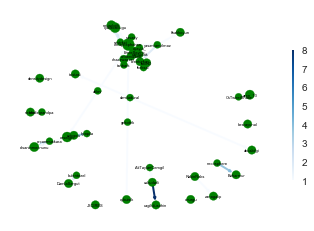

In [78]:
pos = nx.layout.spring_layout(Gm)

node_sizes = [math.sqrt(v+1) * 50 for v in NetMentionInDeg.values()]
M = Gm.number_of_edges()
edge_weights = [int(e[2]) for e in nxMentionEdgeList]
print(edge_weights)

edge_colors = range(1, M)
maxw = max(edge_weights)
minw = min(edge_weights)
edge_colors = edge_weights
edge_alphas = [linear_scaling(edge_colors[i], maxw, minw) for i in range(M)]
#print(edge_alphas)

nodes = nx.draw_networkx_nodes(Gm, pos, node_size=node_sizes, node_color='green', with_labels=True)
edges = nx.draw_networkx_edges(Gm, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=4,
                               edge_color=edge_colors,
                               edge_cmap=plt.cm.Blues,
                               width=2)
labels = nx.draw_networkx_labels(Gm, pos, font_size = 4)

# set alpha value for each edge
for i in range(M): edges[i].set_alpha(edge_alphas[i])

pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
pc.set_array(edge_colors)
plt.colorbar(pc, orientation='vertical', aspect=50, shrink=0.6)

ax = plt.gca()
ax.set_axis_off()
plt.savefig('./output/plots/NetMention.png', dpi = 300)
plt.show()

In [79]:
NetMentionCentDeg['EmreSevinc'], NetMentionInDeg['EmreSevinc'], NetMentionOutDeg['EmreSevinc']

(0.13953488372093023, 5, 1)

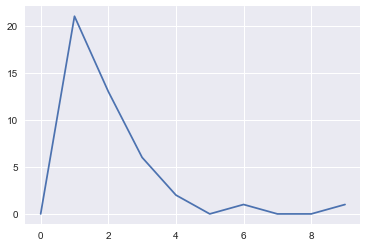

In [80]:
plt.plot(nx.degree_histogram(Gm))

In [81]:
nx.degree_assortativity_coefficient(Gm)

0.016481661991506698

### 4.2 Extracting connectivity metrics from who-retweets-whom network

In [82]:
nxRTEdgeList = get_EdgeList(RT_Network_Internal)
Grt = nx.DiGraph()
Grt.add_weighted_edges_from(nxRTEdgeList)
NetRTInDeg = dict(Grt.in_degree())
NetRTOutDeg = dict(Grt.out_degree())
NetRTCentDeg = dict(nx.degree_centrality(Grt))

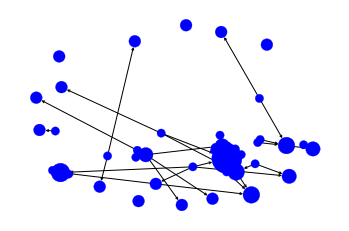

In [83]:
pos = nx.layout.spring_layout(Grt)

node_sizes = [(v+1) * 70 for v in NetRTInDeg.values()]
M = Gm.number_of_edges()
#edge_weights = [int(e[2]) for e in nxRTEdgeList]

#edge_colors = range(1, M)
#maxw = max(edge_weights)
#minw = min(edge_weights)
#edge_colors = edge_weights
#edge_alphas = [linear_scaling(edge_colors[i], maxw, minw) for i in range(M)]
#print(edge_alphas)

nodes = nx.draw_networkx_nodes(Grt, pos, node_size=node_sizes, node_color='blue', with_labels=True)
edges = nx.draw_networkx_edges(Grt, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=5,
                               #edge_color=edge_colors,
                               #edge_cmap=plt.cm.Reds,
                               width=1)
#labels = nx.draw_networkx_labels(Grt, pos, font_size = 4)

# set alpha value for each edge
#for i in range(M): edges[i].set_alpha(edge_alphas[i])

#pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Reds)
#pc.set_array(edge_colors)
#plt.colorbar(pc, orientation='vertical', aspect=50, shrink=0.6)

ax = plt.gca()
ax.set_axis_off()
plt.savefig('./output/plots/NetRT.png', dpi = 300)
plt.show()

In [84]:
NetRTCentDeg['bulentozel'], NetRTInDeg['bulentozel'], NetRTOutDeg['bulentozel']

(0.13043478260869565, 2, 4)

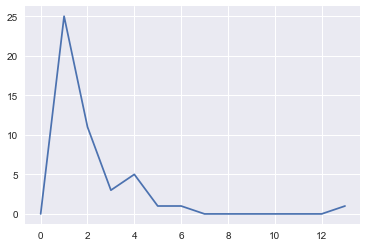

In [85]:
plt.plot(nx.degree_histogram(Grt))

In [86]:
nx.degree_assortativity_coefficient(Grt)

-0.1831689766759752

### 4.3 Extracting connectivity metrics from who-follows-whom network

In [87]:
Gf = nx.DiGraph()
Gf.add_edges_from(folEdgeList)

In [88]:
NetFollowInDeg = dict(Gf.in_degree())
NetFollowOutDeg = dict(Gf.out_degree())
NetFollowCentDeg = dict(nx.degree_centrality(Gf))

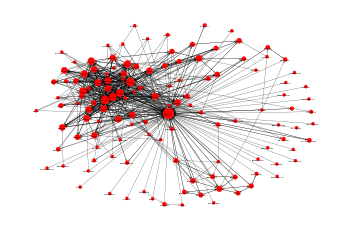

In [89]:
pos = nx.layout.spring_layout(Gf)

node_sizes = [math.sqrt(v+1) * 10 for v in NetFollowInDeg.values()]
M = Gf.number_of_edges()
#edge_weights = [int(e[2]) for e in nxFollowEdgeList]

#edge_colors = range(1, M)
#maxw = max(edge_weights)
#minw = min(edge_weights)
#edge_colors = edge_weights
#edge_alphas = [linear_scaling(edge_colors[i], maxw, minw) for i in range(M)]
#print(edge_alphas)

nodes = nx.draw_networkx_nodes(Gf, pos, node_size=node_sizes, node_color='red', with_labels=True)
edges = nx.draw_networkx_edges(Gf, pos, node_size=node_sizes, arrowstyle='->',
                               arrowsize=4,
                               #edge_color=edge_colors,
                               #edge_cmap=plt.cm.Reds,
                               width=0.2)
labels = nx.draw_networkx_labels(Gf, pos, font_size = 2)

# set alpha value for each edge
#for i in range(M): edges[i].set_alpha(edge_alphas[i])

#pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Reds)
#pc.set_array(edge_colors)
#plt.colorbar(pc, orientation='vertical', aspect=50, shrink=0.6)

ax = plt.gca()
ax.set_axis_off()
plt.savefig('./output/plots/NetFollow.png', dpi = 500)
plt.show()

In [90]:
NetFollowCentDeg['bulentozel'], NetFollowInDeg['bulentozel'], NetFollowOutDeg['bulentozel']

(1.3464566929133859, 128, 43)

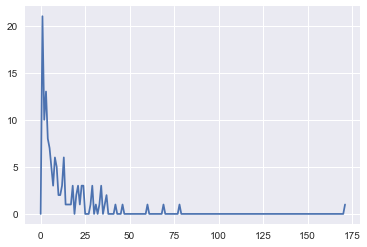

In [91]:
plt.plot(nx.degree_histogram(Gf))

In [92]:
nx.degree_assortativity_coefficient(Gf)

-0.31651133346321442

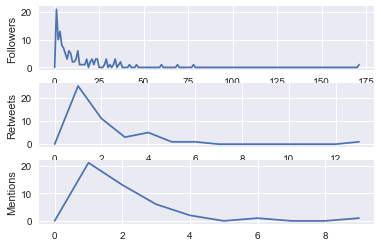

In [93]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.plot(nx.degree_histogram(Gf))
ax1.set_ylabel('Followers')
ax2.plot(nx.degree_histogram(Grt))
ax2.set_ylabel('Retweets')
ax3.plot(nx.degree_histogram(Gm))
ax3.set_ylabel('Mentions')

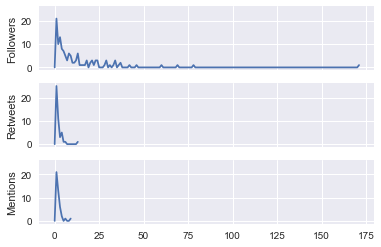

In [94]:
f, (ax1, ax2, ax3) = plt.subplots(3, 1, sharey=True, sharex=True)
ax1.plot(nx.degree_histogram(Gf))
ax1.set_ylabel('Followers')
ax2.plot(nx.degree_histogram(Grt))
ax2.set_ylabel('Retweets')
ax3.plot(nx.degree_histogram(Gm))
ax3.set_ylabel('Mentions')

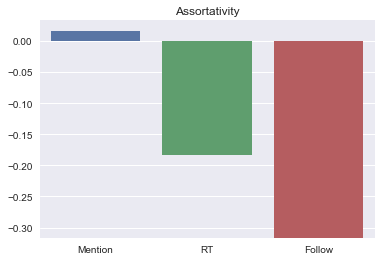

In [95]:
x = ["Mention", "RT", 'Follow']
y = [nx.degree_assortativity_coefficient(Gm),
     nx.degree_assortativity_coefficient(Grt),
    nx.degree_assortativity_coefficient(Gf)]
ax = sns.barplot(x=x, y=y)
ax.set_title('Assortativity')

In [96]:
NetRTInDeg

{'AliTaylanCemgil': 1,
 'CsTweetShare': 1,
 'EmreSevinc': 4,
 'JSCIRES': 1,
 'Jakdemir': 1,
 'Radyo1959': 1,
 'RakinRaks': 0,
 'SerraZel': 0,
 'aren_13': 0,
 'atilev': 1,
 'aytac0x': 0,
 'bitblastr': 0,
 'bpapila': 0,
 'bulentozel': 2,
 'cagilulusahin': 3,
 'chazzwazzer': 0,
 'chrisjstephensn': 12,
 'damladural': 1,
 'dariomarmo_lama': 0,
 'densitydesign': 1,
 'ercanmuskara': 1,
 'erenturkay': 2,
 'filizadastephe1': 0,
 'fkoksal': 0,
 'gekotek': 3,
 'halukdogan': 0,
 'itechD': 0,
 'kkakkoyun': 2,
 'mefallit': 0,
 'mericsucuk': 0,
 'neurolojik': 0,
 'niceyildiz': 1,
 'onurgu': 3,
 'oyayla_': 1,
 'oykuisik': 0,
 'playgen': 1,
 'rukiyeonal': 0,
 'sevtrkci': 0,
 'strafor': 0,
 'tanbark': 0,
 'tugcetackin': 2,
 'uctopcu': 0,
 'uskudarli': 3,
 'yasarcanyilmaz': 0,
 'yilmazsd': 0,
 'zanagalip': 1,
 'zeuran': 1}

In [97]:
SummaryNet = dict()
for n in followers:
    inM,inRT,inF = 0,0,0
    if n in NetFollowInDeg.keys():
        inF = NetFollowInDeg[n]
    if n in NetRTInDeg.keys():
        inRT = NetRTInDeg[n]
    if n in NetMentionInDeg.keys():
        inM = NetMentionInDeg[n]      
    outM,outRT,outF = 0,0,0
    if n in NetFollowOutDeg.keys():
        outF = NetFollowOutDeg[n]
    if n in NetRTOutDeg.keys():
        outRT = NetRTOutDeg[n]
    if n in NetMentionOutDeg.keys():
        outM = NetMentionOutDeg[n]      
    cM,cRT,cF = 0,0,0
    if n in NetFollowCentDeg.keys():
        cF = NetFollowCentDeg[n]
    if n in NetRTCentDeg.keys():
        cRT = NetRTCentDeg[n]
    if n in NetMentionCentDeg.keys():
        cM = NetMentionCentDeg[n] 
    SummaryNet[n] = {
        'MentionIn': inM,
        'MentionOut': outM,
        'MentionCent': cM,
        'RTIn': inRT,
        'RTOut': outRT,
        'RTCent': cRT,
        'FollowIn': inF,
        'FollowOut': outF,
        'FollowCent': cF}

In [98]:
df_SummaryNet = pd.DataFrame.from_dict(SummaryNet, orient='index')
df_SummaryNet = df_SummaryNet.sort_values(by = ['MentionIn','RTIn','FollowIn'], ascending=False)

In [99]:
df_SummaryNet.head()

,MentionIn,MentionOut,MentionCent,RTIn,RTOut,RTCent,FollowIn,FollowOut,FollowCent
chrisjstephensn,7,2,0.209302,12,1,0.282609,1,12,0.102362
EmreSevinc,5,1,0.139535,4,0,0.086957,0,15,0.118110
ozselgin,3,1,0.093023,0,0,0.000000,12,12,0.188976
iyiailecocugu,3,1,0.093023,0,0,0.000000,4,4,0.062992
elsaninmecnunu,2,0,0.046512,0,0,0.000000,14,10,0.188976


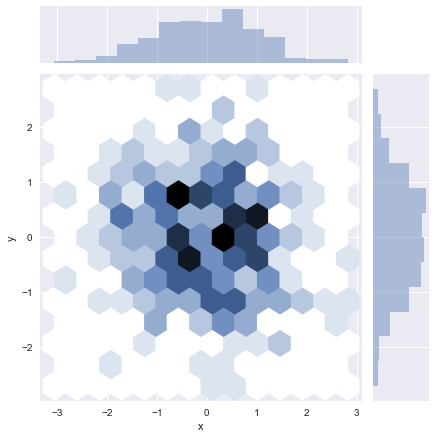

In [100]:
x, y = np.random.randn(2, 300)
g = (sns.jointplot(x, y, kind="hex", stat_func=None).set_axis_labels("x", "y"))

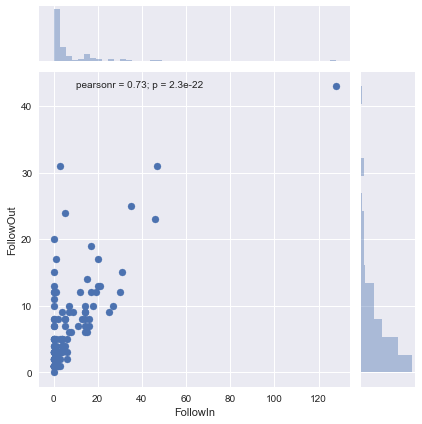

In [101]:
sns.jointplot(x='FollowIn', y='FollowOut', data=df_SummaryNet, kind="scatter")

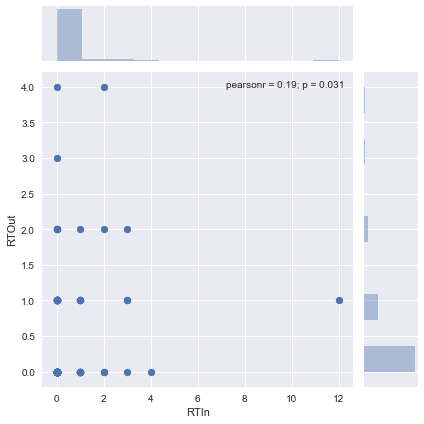

In [102]:
sns.jointplot(x='RTIn', y='RTOut', data=df_SummaryNet, kind="scatter")

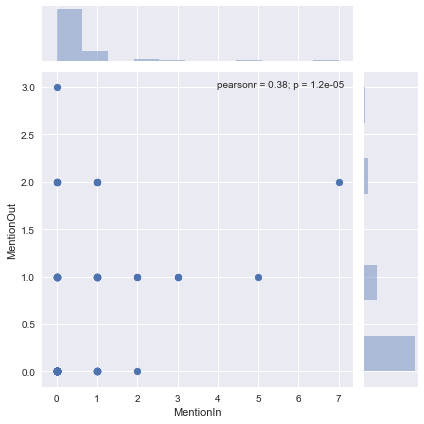

In [103]:
sns.jointplot(x='MentionIn', y='MentionOut', data=df_SummaryNet, kind="scatter")

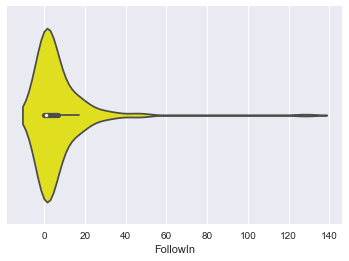

In [104]:
sns.violinplot(x="FollowIn", data=df_SummaryNet, color='yellow', orient='h')

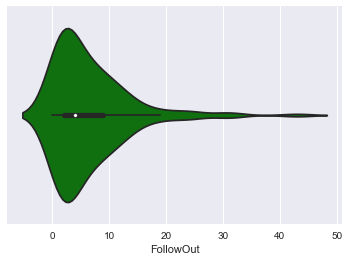

In [105]:
sns.violinplot(x="FollowOut", data=df_SummaryNet, color='green', orient='h')

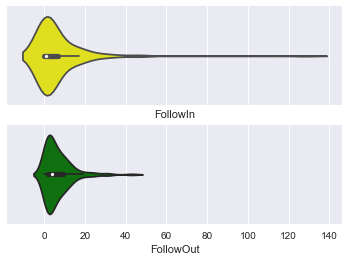

In [106]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
sns.violinplot(x="FollowIn", data=df_SummaryNet, color='yellow', orient='h',  ax = ax1)
sns.violinplot(x="FollowOut", data=df_SummaryNet, color='green', orient='h', ax = ax2)

### 4.4 Analyzing retweet stats
 - **nTweet** : Number of tweets from the follower that were available (up to latest 200 was possible.)
 - **nRTweet** : Number of retweets out of those available tweets.
 - **RTweetDiffusion** : A simple information propagation measure. Here it is the ratio of the retweets to the tweets. *(1 - RTweetDiffusion)* could be interpreted as a information sourcing/originating behavioral measure.


- **RTPopularity** : Of all harvested tweets how often the tweets from the follower is retweeted by the other followers.
- **RTInternal** : Of all the retweets by the follower, the number of times the follower is retweeting the tweet of another followers from the community. 
- **RTExternal** : Of all the retweets by the follower, the number of times the follower is retweeting a tweet from a non-follower user.
- **RTCohesion** : The ratio of the internal tweets to the total retweets. The measure can be used as a proxy on 'to what extend the community under investigation is within the focus of the user?'. A cumulative statistics over all the followers may give an idea on the cohesion between followers.


In [107]:
RT_Stats = get_rt_ratios(curated)
pp.pprint(RT_Stats)

{ '46Ylddmr': {'nRTweet': 0, 'nTweet': 1, 'rDiffusion': 0.0},
  '96MEHMETALI': {'nRTweet': 0, 'nTweet': 11, 'rDiffusion': 0.0},
  'AkifMag': {'nRTweet': 4, 'nTweet': 200, 'rDiffusion': 0.02},
  'AliTaylanCemgil': { 'nRTweet': 164,
                       'nTweet': 196,
                       'rDiffusion': 0.8367346938775511},
  'Anjazvezdica': {'nRTweet': 1, 'nTweet': 1, 'rDiffusion': 1.0},
  'BKartheuser': { 'nRTweet': 7,
                   'nTweet': 121,
                   'rDiffusion': 0.05785123966942149},
  'Baharmur': {'nRTweet': 7, 'nTweet': 14, 'rDiffusion': 0.5},
  'CaiAmir': {'nRTweet': 0, 'nTweet': 1, 'rDiffusion': 0.0},
  'CsTweetShare': {'nRTweet': 0, 'nTweet': 9, 'rDiffusion': 0.0},
  'DVisotto': {'nRTweet': 0, 'nTweet': 0, 'rDiffusion': 0},
  'DamlaSargut': { 'nRTweet': 74,
                   'nTweet': 192,
                   'rDiffusion': 0.3854166666666667},
  'DianePayne12': { 'nRTweet': 156,
                    'nTweet': 199,
                    'rDiffusion': 0.783919

In [108]:
RT_Network_Cohesion = get_cohesion_ratios(RT_Network, followers)

In [109]:
pp.pprint(RT_Network_Cohesion)

{ '46Ylddmr': {'in': 0, 'out': 0, 'ratio': 0},
  '96MEHMETALI': {'in': 0, 'out': 0, 'ratio': 0},
  'AkifMag': {'in': 0, 'out': 4, 'ratio': 0.0},
  'AliTaylanCemgil': {'in': 2, 'out': 162, 'ratio': 0.012195121951219513},
  'Anjazvezdica': {'in': 0, 'out': 1, 'ratio': 0.0},
  'BKartheuser': {'in': 0, 'out': 7, 'ratio': 0.0},
  'Baharmur': {'in': 0, 'out': 7, 'ratio': 0.0},
  'CaiAmir': {'in': 0, 'out': 0, 'ratio': 0},
  'CsTweetShare': {'in': 0, 'out': 0, 'ratio': 0},
  'DVisotto': {'in': 0, 'out': 0, 'ratio': 0},
  'DamlaSargut': {'in': 0, 'out': 74, 'ratio': 0.0},
  'DianePayne12': {'in': 0, 'out': 156, 'ratio': 0.0},
  'EinarJonErlings': {'in': 0, 'out': 116, 'ratio': 0.0},
  'EmreSevinc': {'in': 0, 'out': 2, 'ratio': 0.0},
  'EstebanFabio': {'in': 0, 'out': 0, 'ratio': 0},
  'Goran1st': {'in': 0, 'out': 0, 'ratio': 0},
  'GulcinOymak': {'in': 0, 'out': 0, 'ratio': 0},
  'HeberlerHA': {'in': 0, 'out': 6, 'ratio': 0.0},
  'JSCIRES': {'in': 26, 'out': 148, 'ratio': 0.14942528735632185},

In [110]:
RT_Popularity = get_popularity(RT_Network)

In [111]:
RT_Popularity['OyveOtesi']

11

### 4.5 Analyzing mentions stats

- **MentionPopularity** :  Of the all harvested tweets how often the follower is mentioned by the other followers.
- **MentionInternal** : Of all the mentions by the follower the number of times the follower is mentioning the other followers of the community members. 
- **MentionExternal** : Of all the mentions by the follower the number of times the follower is mentioning the non-followers of the the community members.
- **MentionCohesion** : The ratio of the internal mentions to the total mentions. The measure can be used as a proxy on 'to what extend the community under investigation is within the focus of the user. A cumulative statistics over all the followers may give an idea on the cohesion between followers.

In [112]:
Mention_Network_Cohesion = get_cohesion_ratios(Mention_Network, followers)

In [113]:
pp.pprint(Mention_Network_Cohesion)

{ '46Ylddmr': {'in': 0, 'out': 0, 'ratio': 0},
  '96MEHMETALI': {'in': 0, 'out': 3, 'ratio': 0.0},
  'AkifMag': {'in': 0, 'out': 7, 'ratio': 0.0},
  'AliTaylanCemgil': {'in': 1, 'out': 27, 'ratio': 0.03571428571428571},
  'Anjazvezdica': {'in': 0, 'out': 0, 'ratio': 0},
  'BKartheuser': {'in': 0, 'out': 41, 'ratio': 0.0},
  'Baharmur': {'in': 0, 'out': 5, 'ratio': 0.0},
  'CaiAmir': {'in': 0, 'out': 1, 'ratio': 0.0},
  'CsTweetShare': {'in': 1, 'out': 7, 'ratio': 0.125},
  'DVisotto': {'in': 0, 'out': 0, 'ratio': 0},
  'DamlaSargut': {'in': 0, 'out': 20, 'ratio': 0.0},
  'DianePayne12': {'in': 0, 'out': 79, 'ratio': 0.0},
  'EinarJonErlings': {'in': 0, 'out': 38, 'ratio': 0.0},
  'EmreSevinc': {'in': 1, 'out': 283, 'ratio': 0.0035211267605633804},
  'EstebanFabio': {'in': 0, 'out': 0, 'ratio': 0},
  'Goran1st': {'in': 0, 'out': 2, 'ratio': 0.0},
  'GulcinOymak': {'in': 0, 'out': 4, 'ratio': 0.0},
  'HeberlerHA': {'in': 0, 'out': 22, 'ratio': 0.0},
  'JSCIRES': {'in': 1, 'out': 128, 'ra

In [114]:
# Nonzero ones are returned
Mention_Popularity = get_popularity(Mention_Network)

In [115]:
Mention_Popularity['sozluk']

7

#### Identifying important external nodes


##### Cehcking the source of retweets

In [116]:
RT_Network_External = select_subnet(RT_Network, followers, isin = False)

In [117]:
RT_Network_External['EinarJonErlings']

{'A_Finnbogason': 1,
 'AlbertoRusso76': 7,
 'AndreaRoventini': 3,
 'BBCBreaking': 1,
 'CentralBanking_': 1,
 'EinsteinIS': 1,
 'IMFNews': 1,
 'IcelandicEcon': 10,
 'Jon_Gnarr': 5,
 'KathyLette': 1,
 'Kjarninn': 7,
 'LFCAnfieldFans': 1,
 'LSE_SRC': 1,
 'MP_Innovation': 1,
 'MacroPru': 2,
 'MaggiHalld': 1,
 'MarcoRaberto': 5,
 'MoFIceland': 1,
 'Optus': 1,
 'POTUS44': 1,
 'Reuters': 1,
 'Slate': 1,
 'TheBubbleBubble': 1,
 'TheEconomist': 1,
 'Ulrike_Boehm': 1,
 'WSJecon': 1,
 'Wu_Tang_Finance': 1,
 'asgeirbt': 3,
 'eaepe': 2,
 'ecb': 4,
 'fastFT': 5,
 'geirfreysson': 1,
 'giorgiofagiolo': 1,
 'gunnarsigur': 1,
 'jojokejohn': 1,
 'maggikubein': 1,
 'martinwolf_': 1,
 'monstersandmen': 1,
 'nutiminn': 1,
 'paulkrugman': 5,
 'profsufi': 2,
 'rickygervais': 1,
 'sfiscience': 1,
 'stiglitzian': 2,
 'thordursnaer': 1,
 'tsipras_eu': 2,
 'uni_iceland': 1,
 'visir_is': 2,
 'wef': 1,
 'wonkmonk_': 14,
 'yanisvaroufakis': 3}

In [118]:
pp.pprint(RT_Network_Internal['EinarJonErlings'])

{}


In [119]:
RT_Popularity_External = get_popularity(RT_Network_External)

In [120]:
df_external_RT = pd.DataFrame.from_dict(RT_Popularity_External, orient='index')
df_external_RT.columns = ['Count']
df_external_RT.head(10)

,Count
kadinyazilimci,5
pratikbibilgi,3
tgezginis,1
serakadigil,3
AmaEksi,1
timblnt,1
say_cem,28
MagmaDergisi,1
haluklevent,1
Bilim_Akademisi,1


##### Cehcking the mentions of the community members

In [121]:
M_Network_External = select_subnet(Mention_Network, followers, isin = False)
M_Popularity_External = get_popularity(M_Network_External)
df_external_M = pd.DataFrame.from_dict(M_Popularity_External, orient='index')
df_external_M.columns = ['Count']
df_external_M.head()
df_external_M = df_external_M.sort_values(by = 'Count', ascending = False)
df_external_M.head(11)

,Count
YouTube,125
simendiferlerin,49
fkadev,37
solhaberportali,36
,33
gizemtalay,31
yankeMOFO,28
bsbomonti,24
gokceeyalcn,23
youtube,23


### 4.6 Tabulating the summary of results

In [122]:
Summary = dict()
for n in followers:
    PopM,PopRT,nT,nRT,rDiff = 0,0,0,0,0
    if n in Mention_Popularity.keys():
        PopM = Mention_Popularity[n]
    if n in RT_Popularity.keys():
        PopRT = RT_Popularity[n]
    if n in RT_Stats.keys():
        nT = RT_Stats[n]['nTweet']
        nRT = RT_Stats[n]['nRTweet']
        rDiff = RT_Stats[n]['rDiffusion']
    inM, outM, rM, inRT, outRT, rRT, nF = 0,0,0,0,0,0,0 
    if n in Mention_Network_Cohesion.keys():
        inM = Mention_Network_Cohesion[n]['in']
        outM = Mention_Network_Cohesion[n]['out']
        rM = Mention_Network_Cohesion[n]['ratio']
    if n in RT_Network_Cohesion.keys():
        inRT = RT_Network_Cohesion[n]['in']
        outRT = RT_Network_Cohesion[n]['out']
        rRT = RT_Network_Cohesion[n]['ratio']
    if n in FoFollowers['distro'].keys():
        nF = FoFollowers['distro'][n]
    Summary[n] = {
        'MentionPopularity':PopM,
        'RTPopularity':PopRT,
        'FollowerCount':nF,
        'RTweetDiffusion':rDiff,
        'nTweet':nT,
        'nRTweet':nRT,
        'MentionInternal': inM,
        'MentionExternal': outM,
        'MentionCohesion': rM,
        'RTInternal': inRT,
        'RTExternal': outRT,
        'RTCohesion': rRT}
   

In [123]:
#pp.pprint(Summary)

In [124]:
df_Summary = pd.DataFrame.from_dict(Summary, orient='index')
df_Summary = df_Summary.sort_values(by = ['MentionPopularity',
                                          'FollowerCount',
                                          'RTPopularity',
                                          'nTweet',
                                          'MentionCohesion',
                                          'RTCohesion', 
                                          'nRTweet'], ascending=False)

In [125]:
df_Summary.head(10)

,MentionPopularity,RTPopularity,FollowerCount,RTweetDiffusion,nTweet,nRTweet,MentionInternal,MentionExternal,MentionCohesion,RTInternal,RTExternal,RTCohesion
EmreSevinc,13,4,188,0.010000,200,2,1,283,0.003521,0,2,0.000000
elsaninmecnunu,9,0,1145,0.595960,198,118,0,33,0.000000,0,118,0.000000
ozselgin,9,0,348,0.225000,200,45,4,171,0.022857,0,45,0.000000
onurgu,8,4,856,0.266332,199,53,8,90,0.081633,2,51,0.037736
chrisjstephensn,7,36,569,0.095000,200,19,5,134,0.035971,1,18,0.052632
taistasi,5,0,255,0.387755,196,76,0,108,0.000000,0,76,0.000000
iyiailecocugu,5,0,115,0.750000,200,150,2,64,0.030303,0,150,0.000000
chazzwazzer,4,0,332,0.346939,196,68,1,19,0.050000,3,65,0.044118
neurolojik,4,0,116,0.626943,193,121,2,42,0.045455,2,119,0.016529
densitydesign,2,1,971,0.510000,200,102,2,87,0.022472,1,101,0.009804


In [126]:
sns.set(style="whitegrid")

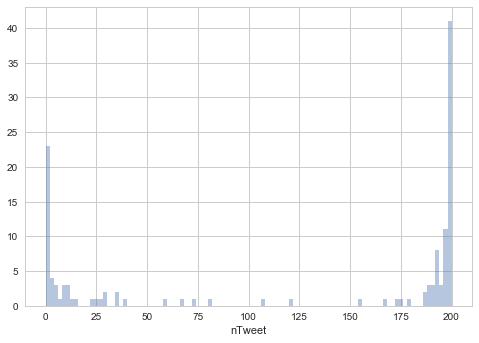

In [127]:
sns.distplot(df_Summary.nTweet, bins=100, kde=False)

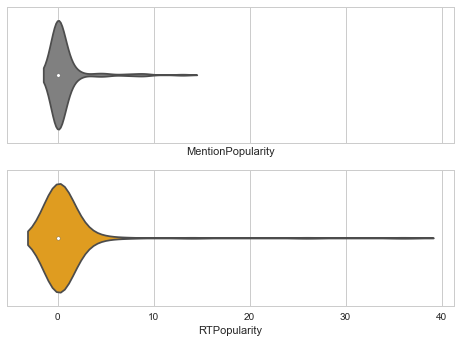

In [128]:
f, axes = plt.subplots(2, 1, sharex=True)
#f, axes = plt.subplots(2, 2)
#sns.violinplot(x="MentionPopularity", data=df_Summary, orient='v' , ax=axes[0,0])
sns.violinplot(x="MentionPopularity", data=df_Summary, orient='h', color='grey', ax=axes[0])
sns.violinplot(x="RTPopularity", data=df_Summary, orient='h', color='orange', ax=axes[1])

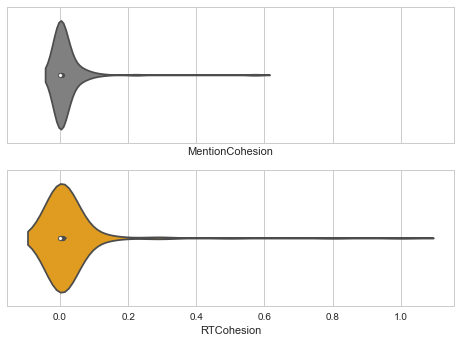

In [129]:
f, axes = plt.subplots(2, 1, sharex=True)
sns.violinplot(x="MentionCohesion", data=df_Summary, orient='h', color='grey', ax=axes[0])
sns.violinplot(x="RTCohesion", data=df_Summary, orient='h', color='orange', ax=axes[1])

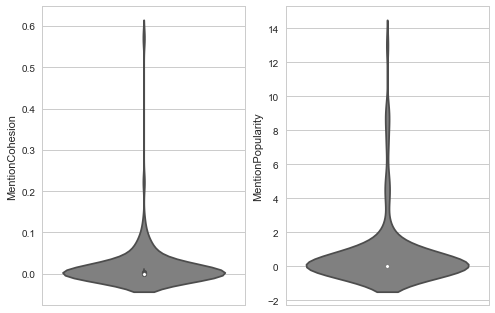

In [130]:
f, axes = plt.subplots(1, 2)
sns.violinplot(x="MentionCohesion", data=df_Summary, orient='v', color='grey', ax=axes[0])
sns.violinplot(x="MentionPopularity", data=df_Summary, orient='v', color='grey', ax=axes[1])

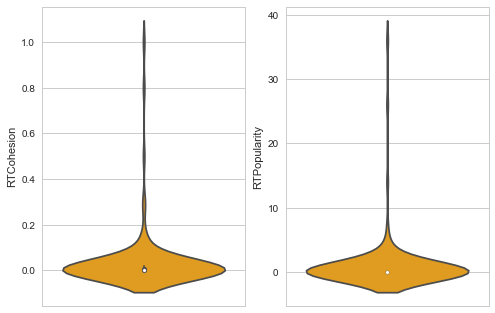

In [131]:
f, axes = plt.subplots(1, 2)
sns.violinplot(x="RTCohesion", data=df_Summary, orient='v', color='orange', ax=axes[0])
sns.violinplot(x="RTPopularity", data=df_Summary, orient='v', color='orange', ax=axes[1])

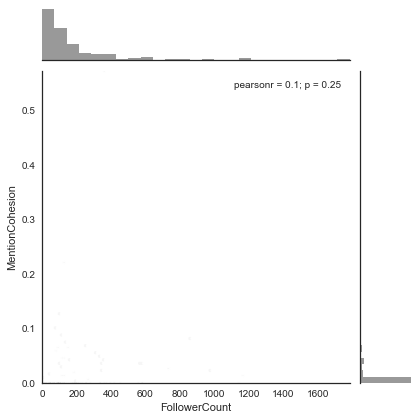

In [132]:
with sns.axes_style("white"):
    sns.jointplot(x='FollowerCount', y='MentionCohesion', data=df_Summary, kind="hex",  color="k");

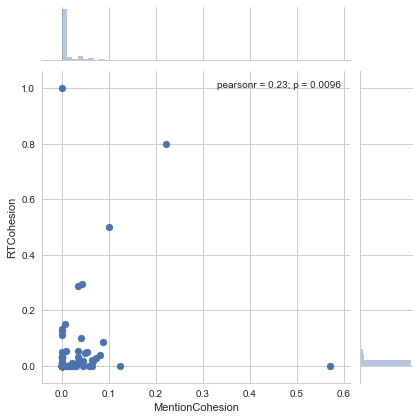

In [133]:
sns.jointplot(x='MentionCohesion', y='RTCohesion', data=df_Summary, kind="scatter")

-----

## 5. Exporting the tabulated results

In [134]:
df_Summary.to_csv('./output/exports/bulentozel_followers.csv')

In [135]:
df_SummaryNet.to_csv('./output/exports/bulentozel_followersNet.csv')

-----

## 6. Topic Modelling

In [136]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d - Emerging Terms: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()
    
def get_top_words(model, feature_names, n_top_words):
    words = dict()
    for topic_idx, topic in enumerate(model.components_):
        words[topic_idx + 1] = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    return words

def get_tops(model, feature_names, n_top_words):
    words = dict()
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d - Emerging Terms: " % topic_idx
        words['T{}'.format(topic_idx + 1)] = ' '.join([feature_names[i]
                                                      for i in topic.argsort()[:-n_top_words - 1:-1]])
    return words


### Identifying major thematic engagements of each member

In [137]:
n_features = 60
n_components = 3
n_top_words = 5
lTopics = list()
for auser in curated.keys():
    #auser = 'DarkMatter_Labs'
    #print(auser)
    keywords = [d['keywords'] for d in curated[auser]['data'] if d['keywords']]
    if len(keywords) < 15: continue
    auser_keywords_str = [' '.join(list(k))for k in keywords]
   
    skip = False
    try:
        tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2,
                                       max_features=n_features,
                                       stop_words='english')
        tfidf = tfidf_vectorizer.fit_transform(auser_keywords_str)
    except ValueError:
        print(auser)
        skip = True
    if skip: continue
    
    #Fitting the NMF model (Frobenius norm) with tf-idf features
    nmf = NMF(n_components=n_components, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)
    tfidf_feature_names = tfidf_vectorizer.get_feature_names()
    
    #print_top_words(nmf, tfidf_feature_names, n_top_words)
    
    kw = get_tops(nmf, tfidf_feature_names, n_top_words)
    #print(kw)
    kw['name'] = auser
    
    lTopics.append(kw)
    
df = pd.DataFrame(lTopics)

In [138]:
df.head()

,T1,T2,T3,name
0,good work need feel team,interesting written work welcome time,welcome team excited written work,kkakkoyun
1,kid comeback pennywise guardian blind,shirt year true story pennywise,year europe true story shirt,ercanmuskara
2,don remember time thought real,need time thought remember real,life time thought remember real,tuncsertatas
3,istanbul studio besiktas tamer berber,brasserie bomonti tamer studio stanbul,stanbul tamer studio servis mototal,alpinotekin
4,ungovforum turkey showing data fix,ello ungovforum turkey showing fix,fix ungovforum turkey showing ello,onurgu


In [139]:
df[df['name'] == 'bulentozel']

,T1,T2,T3,name
42,mood young love mystery jets,direngezi known taksim square action,libyan council interim national transitional,bulentozel


In [140]:
topic1 = df[df['name'] == 'bulentozel'].T1.iloc[0]
topic2 = df[df['name'] == 'bulentozel'].T2.iloc[0]
topic3 = df[df['name'] == 'bulentozel'].T3.iloc[0]

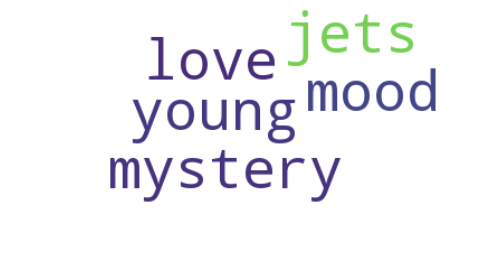

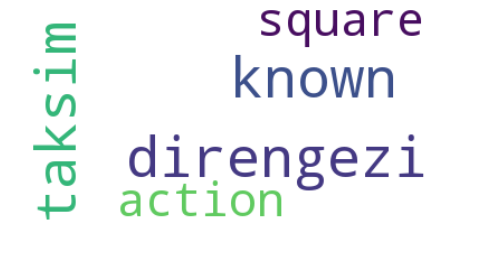

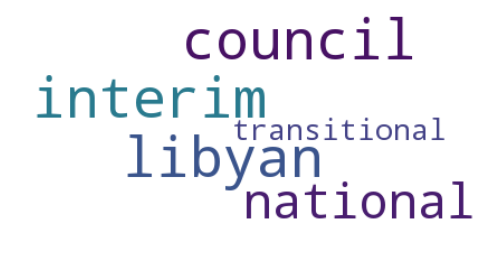

In [141]:
display_wordcloud(topic1, fontsize=50),
display_wordcloud(topic2,fontsize=50),
display_wordcloud(topic3,fontsize=50)

#### Exporting the topics by members

In [142]:
df.to_csv('./output/exports/Topics.csv')

### Probing an institutional account

In [143]:
mT = Tweets()
Dm_curated = curate_user('DarkMatter_Labs', mT, kw=True)

The tweet extractor class is initiated with 0 tweets
DarkMatter_Labs: 200
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at .

Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with 

Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 5
Cleaning process: Initial size of tokens = 5
Reduction due to punctuations and stopwords = 2.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 2
Percentage = 40%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A

Reduction due to punctuations and stopwords = 1.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 1
Percentage = 33%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The 

The total term count reduction during this cleaning process = 1
Percentage = 17%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 5
Cleaning process: Initial size of tokens = 5
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 1
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 1
Percentage = 20%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading

A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 9
Cleaning process: Initial size of tokens = 9
Reduction due to punctuations and stopwords = 4.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 4
Percentage = 44%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 7
Cleaning process: Initial size of tokens = 7
Reduction due to punctuations and stopwords = 4.
Reduction due to all numeral terms = 0
Reduction due t

Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 14
Cleaning process: Initial size of tokens = 14
Reduction due to punctuations and stopwords = 7.
Reduction due to all numeral terms = 1
Reduction due to short terms = 1
Reduction due to rare terms = 0
Reduction due to 

No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...

Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
N

Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 6
Cleaning process: Initial size of tokens = 6
Reduction due to punctuations and stopwords = 4.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 4
Percentage = 67%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A

In [144]:
Dm_curated

(200,
 [{'hashtags': set(),
   'keywords': set(),
   'mentions': set(),
   'rt': True,
   'rt_from': {'indy_johar'},
   'text': ''},
  {'hashtags': set(),
   'keywords': set(),
   'mentions': set(),
   'rt': True,
   'rt_from': {'CassieRobinson'},
   'text': ''},
  {'hashtags': set(),
   'keywords': {'innovation', 'next', 'provocations', 'social', 'years'},
   'mentions': set(),
   'rt': False,
   'rt_from': set(),
   'text': '“10 Provocations for the Next 10 years of Social Innovation”'},
  {'hashtags': set(),
   'keywords': {'begins', 'great', 'restructuring'},
   'mentions': set(),
   'rt': False,
   'rt_from': set(),
   'text': '“The Great Restructuring Begins”'},
  {'hashtags': set(),
   'keywords': set(),
   'mentions': set(),
   'rt': True,
   'rt_from': {'awb58'},
   'text': ''},
  {'hashtags': set(),
   'keywords': {'andamp', 'cities', 'future', 'innovation', 'societal'},
   'mentions': {'indy_johar'},
   'rt': False,
   'rt_from': set(),
   'text': '“Societal Innovation &amp;

In [145]:
cleaned_texts = combine_curated_tweets(Dm_curated)
texts = cleaned_texts['keywords']
hashtags = cleaned_texts['hashtags']

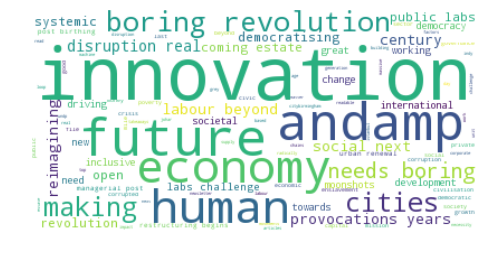

In [146]:
display_wordcloud(texts, fontsize=300, maxwords=100)

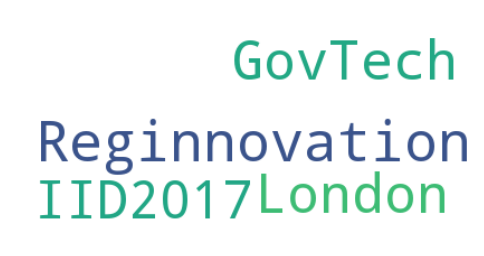

In [147]:
display_wordcloud(hashtags)

In [148]:
harvest_tweets(['DarkMatter_Labs'], fname='./output/tweets/Dm_recent.pickle')

DarkMatter_Labs True
Done: DarkMatter_Labs


({'DarkMatter_Labs'}, set())

In [149]:
Dm_recurated = curate_user('Dm_recent', mT, kw=True)

Dm_recent: 200
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 24
Cleaning process: Initial size of tokens = 24
Reduction due to punctuations and stopwords = 10.
Reduction due to all numeral terms = 0
Reduction due to short terms = 1
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 11
Percentage = 46%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data lo

Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLE

Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, 

Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is p

The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at 

A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0

The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at 

Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
N

No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 32
Cleaning process: Initial size of tokens = 32
Reduction due to punctuations and stopwords = 8.
Reduction due to all numeral terms = 3
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 11
Percentage = 34%
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extr

Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare terms = 0
Reduction due to partially numeral terms = 0
Reduction due to terms with not allowed symbols = 0
The total term count reduction during this cleaning process = 0
COMPLETED.
Configuring the text cleaner ...
No custom stopword list is given, nltk.corpus.stopwords will be used.
File access error at ./data/stopwords_openmaker.txt loading is skipped.
File access error at ./data/specifics_openmaker.txt, data loading is skipped.
A single text is provided.
Extracting the terms ...
Tokenizing the input text ..
Done. Number of terms: 0
Cleaning process: Initial size of tokens = 0
Reduction due to punctuations and stopwords = 0.
Reduction due to all numeral terms = 0
Reduction due to short terms = 0
Reduction due to rare term

In [150]:
cleaned_texts = combine_curated_tweets(Dm_recurated)
texts = cleaned_texts['keywords']
hashtags = cleaned_texts['hashtags']

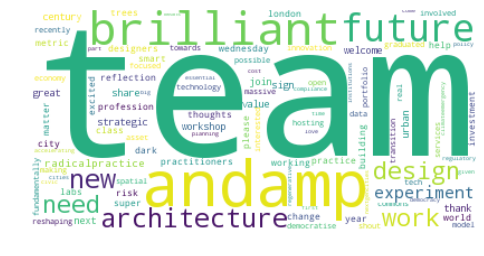

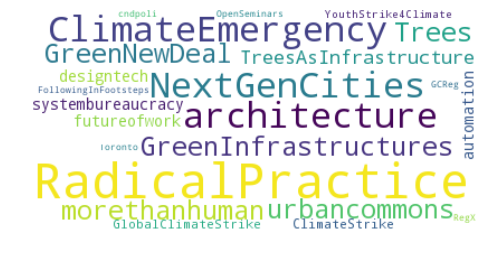

(None, None)

In [151]:
display_wordcloud(texts, fontsize=300, maxwords=100), display_wordcloud(hashtags)